In [1]:
import warnings                              # This block prevents display of harmless warnings, but should be
warnings.filterwarnings('ignore')            # commented out till the experiment final version,
                                             # in order to avoid missing "real" warnings 
from IPython.display import display
import kilroy_was_here                       # Mandatory. Allow access to shared python code from repository root
from audace.jupytools import predestination  # Global Random seed for reproducibilty.
from audace.audiodataset import AudioDataset # Main class for audio dataset handling


# Let's seed the various PRNGs, for reproducibility,
predestination()

EXP_NAME = "05 - SVM BATCH"


# Dataset name is the master key for dataset adressing
# Changing according to the dataset you want to process
DATASET_NAME = 'MAIN1000'

# Initialize Dataset Object. 
ds = AudioDataset(DATASET_NAME)
    
# Display AudioDataset summary    
ds.info()

# Display cardinalities by hive attribute and queen label for samples with no external perturbation
sql = """
    select distinct hive, queen, count(*)
    from samples
    where nobee = 0
    group by hive, queen
    order by hive
    """
display(ds.queryDataFrame(sql))

# Get pandas dataframe containing the columns we will need for this experiments
sql = "select mfcc20, apidictor, queen from samples where nobee = 0"
df = ds.queryDataFrame(sql)

[2020-08-22/21:06:38.707|26.9%|63.8%|0.26GB] ------------------------------------------------------
[2020-08-22/21:06:38.708|00.0%|63.8%|0.26GB] DATASET NAME          : MAIN1000
[2020-08-22/21:06:38.708|00.0%|63.8%|0.26GB] DATASET PATH          : D:\Jupyter\ShowBees\datasets\MAIN1000
[2020-08-22/21:06:38.708|00.0%|63.8%|0.26GB] DATASET DB PATH       : D:\Jupyter\ShowBees\datasets\MAIN1000\MAIN1000.db
[2020-08-22/21:06:38.708|00.0%|63.8%|0.26GB] DATASET SAMPLES PATH  : D:\Jupyter\ShowBees\datasets\MAIN1000\samples
[2020-08-22/21:06:38.709|00.0%|63.8%|0.26GB] NB SOURCE AUDIO FILES : 48
[2020-08-22/21:06:38.709|00.0%|63.8%|0.26GB] SAMPLE RATE           : 22050
[2020-08-22/21:06:38.709|00.0%|63.8%|0.26GB] DURATION              : 1.0
[2020-08-22/21:06:38.709|00.0%|63.8%|0.26GB] OVERLAP               : 0.0
[2020-08-22/21:06:38.709|00.0%|63.8%|0.26GB] NB AUDIO CHUNKS       : 24788
[2020-08-22/21:06:38.710|00.0%|63.8%|0.26GB] ------------------------------------------------------


,hive,queen,count(*)
0,CF001,0.0,14
1,CF003,1.0,3649
2,CJ001,0.0,790
3,GH001,1.0,1396
4,Hive1,0.0,1473
5,Hive1,1.0,2684
6,Hive3,0.0,6545
7,Hive3,1.0,654


In [2]:
from functools import reduce
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from audace.jupytools import iprint

FEATURE_NAME = 'mfcc20'
TEST_FRAC = 0.3
C = 1
GAMMA = 'scale'
REPEAT=100

# Seed the various PRNGs
predestination()


def feature_serie_to_np(s):
    x = np.stack(s)
    shape = x.shape
    return x.reshape(shape[0], reduce((lambda x, y: x * y), shape[1:]) )


def process_svm(param_C, param_gamma):
    # shuffle (and potentially truncate)
    # Not needed, but may help during testing
    df_shuffled = df.sample(frac=1)

    # flatten features array
    X = feature_serie_to_np(df_shuffled[FEATURE_NAME])

    # get labels
    y = df_shuffled['queen']

    scaler = StandardScaler()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_FRAC)

    # Here we perform fair scaling
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    #Create a svm Classifier
    clf = svm.SVC(kernel='rbf', C=param_C, gamma=param_gamma)

    iprint('>>>>> Train')
    #Train the model using the training sets
    clf.fit(X_train, y_train)

    iprint('>>>>> Predict')
    #Predict the response for test dataset
    y_pred = clf.predict(X_test)


    iprint(F"Trained over {len(y_train)} / Tested over {len(y_test)}")
    iprint("Accuracy  :",metrics.accuracy_score(y_test, y_pred))
    iprint("Precision :",metrics.precision_score(y_test, y_pred))
    iprint("Recall    :",metrics.recall_score(y_test, y_pred))
    iprint("F-Measure :",metrics.f1_score(y_test, y_pred))
    
    return metrics.f1_score(y_test, y_pred)

def batch_svm(param_C, param_gamma, n=10):
    res = np.empty(n)
    for i in range(n):
        iprint(F"============== {i} ==============")
        res[i] = process_svm(param_C, param_gamma)

    return res
        

fmeasures = batch_svm(C, GAMMA, n=REPEAT)   

iprint('DONE...')


[2020-08-22/21:08:10.356|16.4%|64.0%|0.34GB] ============== 0 ==============
[2020-08-22/21:08:10.808|31.9%|65.6%|0.45GB] >>>>> Train
[2020-08-22/21:08:34.156|28.3%|64.2%|0.46GB] >>>>> Predict
[2020-08-22/21:08:43.311|27.2%|65.0%|0.46GB] Trained over 12043 / Tested over 5162
[2020-08-22/21:08:43.312|00.0%|65.0%|0.46GB] Accuracy  : 0.9970941495544363
[2020-08-22/21:08:43.316|60.0%|65.0%|0.46GB] Precision : 0.997626582278481
[2020-08-22/21:08:43.320|00.0%|65.0%|0.46GB] Recall    : 0.9964440932437771
[2020-08-22/21:08:43.324|00.0%|65.0%|0.46GB] F-Measure : 0.997034987151611
[2020-08-22/21:08:43.342|33.3%|63.4%|0.34GB] ============== 1 ==============
[2020-08-22/21:08:43.798|27.1%|64.9%|0.45GB] >>>>> Train
[2020-08-22/21:09:07.065|29.7%|65.5%|0.46GB] >>>>> Predict
[2020-08-22/21:09:16.608|31.7%|66.3%|0.46GB] Trained over 12043 / Tested over 5162
[2020-08-22/21:09:16.610|60.0%|66.3%|0.46GB] Accuracy  : 0.996706702828361
[2020-08-22/21:09:16.614|00.0%|66.3%|0.46GB] Precision : 0.998410806515

[2020-08-22/21:16:03.359|31.4%|73.7%|0.47GB] >>>>> Train
[2020-08-22/21:16:26.803|29.6%|71.9%|0.48GB] >>>>> Predict
[2020-08-22/21:16:36.113|28.0%|72.3%|0.48GB] Trained over 12043 / Tested over 5162
[2020-08-22/21:16:36.115|00.0%|72.3%|0.48GB] Accuracy  : 0.9969004261913987
[2020-08-22/21:16:36.118|00.0%|72.3%|0.48GB] Precision : 0.9979781641730692
[2020-08-22/21:16:36.123|00.0%|72.3%|0.48GB] Recall    : 0.9955627269060104
[2020-08-22/21:16:36.127|50.0%|72.3%|0.48GB] F-Measure : 0.9967689822294021
[2020-08-22/21:16:36.146|25.0%|70.7%|0.36GB] ============== 15 ==============
[2020-08-22/21:16:36.729|44.0%|72.2%|0.47GB] >>>>> Train
[2020-08-22/21:17:00.683|31.1%|72.4%|0.46GB] >>>>> Predict
[2020-08-22/21:17:09.831|27.8%|72.7%|0.46GB] Trained over 12043 / Tested over 5162
[2020-08-22/21:17:09.832|00.0%|72.7%|0.46GB] Accuracy  : 0.9963192561022859
[2020-08-22/21:17:09.837|00.0%|72.7%|0.46GB] Precision : 0.9964314036478985
[2020-08-22/21:17:09.841|00.0%|72.7%|0.46GB] Recall    : 0.996036464

[2020-08-22/21:24:51.779|26.2%|74.3%|0.29GB] Trained over 12043 / Tested over 5162
[2020-08-22/21:24:51.781|00.0%|74.3%|0.29GB] Accuracy  : 0.996706702828361
[2020-08-22/21:24:51.785|37.5%|74.3%|0.29GB] Precision : 0.998003992015968
[2020-08-22/21:24:51.788|00.0%|74.3%|0.29GB] Recall    : 0.9952229299363057
[2020-08-22/21:24:51.792|00.0%|74.3%|0.29GB] F-Measure : 0.9966115208291808
[2020-08-22/21:24:51.810|50.0%|72.7%|0.17GB] ============== 29 ==============
[2020-08-22/21:24:52.265|27.2%|74.3%|0.28GB] >>>>> Train
[2020-08-22/21:25:15.708|28.9%|75.1%|0.32GB] >>>>> Predict
[2020-08-22/21:25:24.996|27.7%|75.4%|0.32GB] Trained over 12043 / Tested over 5162
[2020-08-22/21:25:24.997|00.0%|75.4%|0.32GB] Accuracy  : 0.9963192561022859
[2020-08-22/21:25:25.001|33.3%|75.4%|0.32GB] Precision : 0.9984307571596704
[2020-08-22/21:25:25.006|00.0%|75.4%|0.32GB] Recall    : 0.994140625
[2020-08-22/21:25:25.010|00.0%|75.4%|0.32GB] F-Measure : 0.9962810726169505
[2020-08-22/21:25:25.028|37.5%|73.9%|0.19

[2020-08-22/21:32:47.856|29.6%|71.1%|0.29GB] >>>>> Train
[2020-08-22/21:33:10.545|26.4%|70.9%|0.30GB] >>>>> Predict
[2020-08-22/21:33:19.641|26.6%|71.4%|0.30GB] Trained over 12043 / Tested over 5162
[2020-08-22/21:33:19.643|00.0%|71.4%|0.30GB] Accuracy  : 0.9969004261913987
[2020-08-22/21:33:19.647|00.0%|71.4%|0.30GB] Precision : 0.9979943842759728
[2020-08-22/21:33:19.651|00.0%|71.4%|0.30GB] Recall    : 0.9955982392957183
[2020-08-22/21:33:19.655|00.0%|71.4%|0.30GB] F-Measure : 0.9967948717948717
[2020-08-22/21:33:19.671|22.2%|69.8%|0.17GB] ============== 44 ==============
[2020-08-22/21:33:20.131|29.2%|71.3%|0.29GB] >>>>> Train
[2020-08-22/21:33:42.271|26.3%|71.3%|0.29GB] >>>>> Predict
[2020-08-22/21:33:51.109|26.0%|71.1%|0.29GB] Trained over 12043 / Tested over 5162
[2020-08-22/21:33:51.111|33.3%|71.1%|0.29GB] Accuracy  : 0.9963192561022859
[2020-08-22/21:33:51.116|00.0%|71.1%|0.29GB] Precision : 0.9967961553864637
[2020-08-22/21:33:51.120|00.0%|71.1%|0.29GB] Recall    : 0.9956
[202

[2020-08-22/21:40:45.958|26.4%|70.3%|0.29GB] Trained over 12043 / Tested over 5162
[2020-08-22/21:40:45.960|00.0%|70.3%|0.29GB] Accuracy  : 0.9961255327392483
[2020-08-22/21:40:45.964|00.0%|70.3%|0.29GB] Precision : 0.9972155926809865
[2020-08-22/21:40:45.968|00.0%|70.3%|0.29GB] Recall    : 0.9948412698412699
[2020-08-22/21:40:45.972|28.6%|70.3%|0.29GB] F-Measure : 0.9960270162892332
[2020-08-22/21:40:45.989|37.5%|68.8%|0.17GB] ============== 58 ==============
[2020-08-22/21:40:46.445|27.0%|70.1%|0.28GB] >>>>> Train
[2020-08-22/21:41:08.930|26.3%|70.5%|0.30GB] >>>>> Predict
[2020-08-22/21:41:18.017|26.6%|69.7%|0.30GB] Trained over 12043 / Tested over 5162
[2020-08-22/21:41:18.019|00.0%|69.8%|0.30GB] Accuracy  : 0.9969004261913987
[2020-08-22/21:41:18.023|00.0%|69.8%|0.30GB] Precision : 0.99800796812749
[2020-08-22/21:41:18.027|00.0%|69.8%|0.30GB] Recall    : 0.9956279809220986
[2020-08-22/21:41:18.031|00.0%|69.8%|0.30GB] F-Measure : 0.9968165539196181
[2020-08-22/21:41:18.048|33.3%|68.

[2020-08-22/21:48:13.442|29.7%|70.3%|0.28GB] >>>>> Train
[2020-08-22/21:48:34.663|21.2%|66.3%|0.29GB] >>>>> Predict
[2020-08-22/21:48:42.396|14.2%|66.4%|0.29GB] Trained over 12043 / Tested over 5162
[2020-08-22/21:48:42.397|00.0%|66.4%|0.29GB] Accuracy  : 0.9961255327392483
[2020-08-22/21:48:42.401|00.0%|66.4%|0.29GB] Precision : 0.9976780185758514
[2020-08-22/21:48:42.404|00.0%|66.4%|0.29GB] Recall    : 0.9945987654320988
[2020-08-22/21:48:42.407|37.5%|66.4%|0.29GB] F-Measure : 0.9961360123647605
[2020-08-22/21:48:42.423|50.0%|64.9%|0.17GB] ============== 73 ==============
[2020-08-22/21:48:42.817|14.7%|66.3%|0.28GB] >>>>> Train
[2020-08-22/21:49:01.875|13.8%|66.0%|0.29GB] >>>>> Predict
[2020-08-22/21:49:09.323|13.7%|66.1%|0.29GB] Trained over 12043 / Tested over 5162
[2020-08-22/21:49:09.325|00.0%|66.1%|0.29GB] Accuracy  : 0.9978690430065866
[2020-08-22/21:49:09.328|00.0%|66.1%|0.29GB] Precision : 0.9980023971234518
[2020-08-22/21:49:09.331|11.1%|66.1%|0.29GB] Recall    : 0.997603833

[2020-08-22/21:55:42.801|61.1%|72.3%|0.29GB] Trained over 12043 / Tested over 5162
[2020-08-22/21:55:42.804|00.0%|72.3%|0.29GB] Accuracy  : 0.9959318093762107
[2020-08-22/21:55:42.812|00.0%|72.3%|0.29GB] Precision : 0.9979649979649979
[2020-08-22/21:55:42.819|62.5%|72.2%|0.29GB] Recall    : 0.993517017828201
[2020-08-22/21:55:42.827|00.0%|72.3%|0.29GB] F-Measure : 0.995736040609137
[2020-08-22/21:55:42.852|75.0%|71.1%|0.17GB] ============== 87 ==============
[2020-08-22/21:55:43.538|71.3%|73.2%|0.28GB] >>>>> Train
[2020-08-22/21:56:13.209|63.0%|73.6%|0.29GB] >>>>> Predict
[2020-08-22/21:56:25.375|69.0%|70.9%|0.29GB] Trained over 12043 / Tested over 5162
[2020-08-22/21:56:25.379|100.0%|70.9%|0.29GB] Accuracy  : 0.9959318093762107
[2020-08-22/21:56:25.388|00.0%|70.9%|0.29GB] Precision : 0.9972321075523922
[2020-08-22/21:56:25.396|75.0%|70.9%|0.29GB] Recall    : 0.9944794952681388
[2020-08-22/21:56:25.405|00.0%|70.9%|0.29GB] F-Measure : 0.9958538993089832
[2020-08-22/21:56:25.434|82.4%|69

Mean   : 0.9968894474448059
Median : 0.9968159202719109
std    : 0.0007890650660348183
var    : 6.226236784365322e-07
Min    : 0.9949627241587748
Max    : 0.9989957822855995


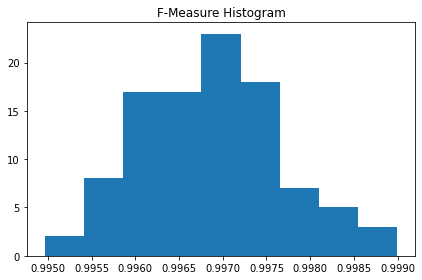

In [3]:
import matplotlib.pyplot as plt
from audace.plotters import save_fig

print("Mean   :", fmeasures.mean())
print("Median :", np.median(fmeasures))
print("std    :", fmeasures.std())
print("var    :", fmeasures.var())
print("Min    :", fmeasures.min())
print("Max    :", fmeasures.max())

_ = plt.hist(fmeasures, bins='auto')
plt.title("F-Measure Histogram")

figure_name = "F-Measure Histogram " + F" - ({DATASET_NAME}) - C{C} - G{GAMMA} -R{REPEAT}"

save_fig(figure_name)